In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
# pltのlabelで日本語を使うために必要なモジュールをインポート
import japanize_matplotlib
from matplotlib import rc
from matplotlib.font_manager import FontProperties
from scipy.stats import norm
from scipy.linalg import expm
from math import factorial
import tqdm
import pandas as pd

In [3]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr

pandas2ri.activate()
yuima = importr("yuima")

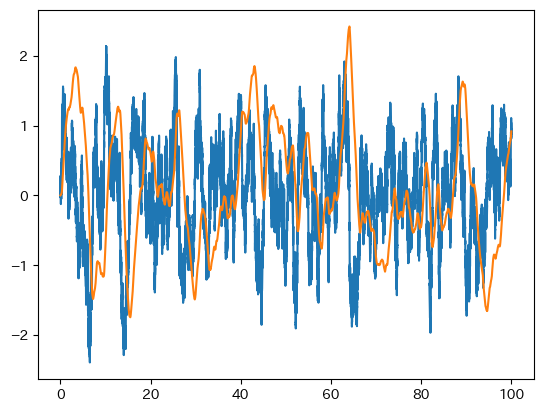

In [4]:
import numpy as np
import rpy2

def linear_Z(theta, t_max, dt, seed):
    # np.random.seed(seed)

    theta1 = theta[0]
    theta21 = theta[1]
    theta22 = theta[2]
    theta3 = theta[3]

    ro.r('options(warn=-1)')

    ro.r(f'drift = c("-theta21*x1-theta22*x2", "theta3*x1")')
    ro.r(f'diffusion = matrix(c("theta1", "0", "0", "0"), 2, 2)')
    ro.r('model = setModel(drift=drift, diffusion=diffusion, state.var=c("x1", "x2"))')

    N = int(t_max/dt)
    ro.r(f'samp = setSampling(Terminal={t_max}, n={N})')
    ro.r('yuima = setYuima(model=model, sampling=samp)')
    
    ro.r(f'set.seed({seed})')
    ro.r('xinit = c(0, 0)')
    ro.r(f'true.par = list(theta1={theta1}, theta21={theta21}, theta22={theta22}, theta3={theta3})')
    ro.r('sim = simulate(yuima, xinit=xinit, true.par=true.par)')
    
    Z_t = ro.r('sim@data@original.data')

    return Z_t.T

# 使用例
theta = [1,1,1,1]
t_max = 100.0  # 最大時間の例
dt = 0.001  # タイムステップの例
seed = 0  # ランダムシードの例

Z_t = linear_Z(theta, t_max, dt, 2)
# Z_tの形を(N+1, 2)に変更
plt.plot(np.linspace(0, t_max, int(t_max/dt)+1),Z_t[0])
plt.plot(np.linspace(0, t_max, int(t_max/dt)+1),Z_t[1])

$$
dX_t = -X_t dt + dW_t\\
dY_t = X_t dt
$$

$Y_{40} = \sum_{i=1}^{40}X_{t_i}\Delta t_i = 0$

$Y_{41} = Y_{40} + X_{t_{41}}\Delta t_{41} = X_{t_{41}}\Delta t_{41}$

In [5]:
def compute_a(theta,k0):
    theta21 = theta[1]
    theta22 = theta[2]
    theta3 = theta[3]
    a0 = 1
    a1 = -theta21
    A0 = np.array([[0,1],[-theta22*theta3,-theta21]])
    An = np.array([np.linalg.matrix_power(A0,n) for n in np.arange(k0+1)])
    x0 = np.array([a0,a1])
    xn = np.einsum('ijk,k->ij',An,x0)
    return xn[:,0]
def compute_b(theta,k0):
    theta21 = theta[1]
    theta22 = theta[2]
    theta3 = theta[3]
    b0 = 0
    b1 = -theta22
    B0 = np.array([[0,1],[-theta22*theta3,-theta21]])
    Bn = np.array([np.linalg.matrix_power(B0,n) for n in np.arange(k0+1)])
    x0 = np.array([b0,b1])
    xn = np.einsum('ijk,k->ij',Bn,x0)
    return xn[:,0]

In [34]:
a = compute_a([1,1,1,1],10)
b = compute_b([1,1,1,1],10)

In [21]:
# def compute_s(a,theta, k0):
#     theta1 = theta[0]
#     theta3 = theta[3]
    
#     m = np.arange(k0 + 1)
#     k = np.arange(k0 )
#     l = np.arange(k0 )
    
#     m_grid, k_grid,l_grid = np.meshgrid(m, k, l,indexing='ij')
#     valid_mask = (k_grid + l_grid == m_grid)

#     m_grid = m_grid*valid_mask
#     k_grid = k_grid*valid_mask
#     l_grid = l_grid*valid_mask
    
#     a_k = a[k_grid] * valid_mask
#     a_l = a[l_grid] * valid_mask
    
#     fact_11 = 1/((m_grid +1)*scipy.special.factorial(k_grid )*scipy.special.factorial(l_grid))
#     fact_12 = 1/((m_grid +2)*scipy.special.factorial(k_grid +1)*scipy.special.factorial(l_grid))
#     fact_22 = 1/((m_grid +3)*scipy.special.factorial(k_grid +1)*scipy.special.factorial(l_grid+1))
    
#     mat11 = np.einsum('ijk->i',theta1**2 * a_k * a_l* fact_11)
#     mat12 = np.einsum('ijk->i',theta1**2 * theta3  * a_k * a_l * fact_12)
#     mat22 = np.einsum('ijk->i',theta1**2 * theta3**2 * a_k * a_l * fact_22)
    
#     s = np.zeros((k0 + 1, 2, 2))
#     s[:, 0, 0] = mat11
#     s[:, 0, 1] = mat12
#     s[:, 1, 0] = mat12
#     s[:, 1, 1] = mat22
    
#     return s




In [6]:
def compute_s(a,theta, k0):
    theta1 = theta[0]
    theta3 = theta[3]
    
    m = np.arange(k0 + 1)
    k = np.arange(k0 )
    l = np.arange(k0 )
    
    m_grid, k_grid,l_grid = np.meshgrid(m, k, l,indexing='ij')
    valid_mask = (k_grid + l_grid == m_grid)

    m_grid = m_grid*valid_mask
    k_grid = k_grid*valid_mask
    l_grid = l_grid*valid_mask
    
    a_k = a[k_grid] * valid_mask
    a_l = a[l_grid] * valid_mask
    
    fact_11 = 1/((m_grid +1)*scipy.special.factorial(k_grid )*scipy.special.factorial(l_grid))
    fact_12 = 1/((m_grid +2)*scipy.special.factorial(k_grid +1)*scipy.special.factorial(l_grid))
    fact_22 = 1/((m_grid +3)*scipy.special.factorial(k_grid +1)*scipy.special.factorial(l_grid+1))
    
    mat11 = np.einsum('ijk->i',theta1**2 * a_k * a_l* fact_11)
    mat12 = np.einsum('ijk->i',theta1**2 * theta3  * a_k * a_l * fact_12)
    mat22 = np.einsum('ijk->i',theta1**2 * theta3**2 * a_k * a_l * fact_22)
    
    s = np.zeros((k0 + 1, 1, 1))
    s[:, 0, 0] = mat11
    
    
    return s




In [23]:
import numpy as np
import scipy.special


def calculate_d_e(s):
    k0 = np.shape(s)[0] - 1  # k0を変更
    d = np.zeros_like(s)
    e = np.zeros(k0 + 1)
    
    d[0] = np.linalg.inv(np.array(s[0]))
    
    for k in range(1, k0 + 1):
        p_idx, q_idx ,r_idx= np.meshgrid(np.arange(k), np.arange(k),np.arange(k), indexing='ij')
        valid_indices = (p_idx+q_idx+r_idx == k-1)
        factorial_k = scipy.special.factorial(k -1)
        
        p_valid = p_idx[valid_indices]
        q_valid = q_idx[valid_indices]
        r_valid = r_idx[valid_indices]
        
        comb_factor = 1/ (k *scipy.special.factorial(p_valid) * scipy.special.factorial(q_valid) * scipy.special.factorial(r_valid))
        
        d[k] =  -np.einsum('n,nij,njk,nkl->il', comb_factor,d[p_valid], s[q_valid + 1], d[r_valid])
    
    e[0] = np.log(np.linalg.det(s[0]))
    
    for k in range(1, k0 + 1):
        p_idx, q_idx = np.meshgrid(np.arange(k),np.arange(k),indexing = 'ij')
        valid_indices = (p_idx+q_idx == k-1)
        p_valid = p_idx[valid_indices]
        q_valid = q_idx[valid_indices]
        
        comb_factor = 1 / (k* scipy.special.factorial(p_valid) * scipy.special.factorial(q_valid))
        e[k] = -np.einsum('n,nij,nij->', comb_factor, d[p_valid + 1], s[q_valid])
        
    return d, e


In [24]:
# def D(a,b,Z,theta,k0,h):
#     theta1 = theta[0]
#     theta21 = theta[1]
#     theta22 = theta[2]
#     theta3 = theta[3]
#     Z1 = Z[:,1:]
#     Z2 = Z[:,:-1]
#     x = Z1[0]
#     y = Z1[1]
#     x_ = Z2[0]
#     y_ = Z2[1]
#     x = x[:,np.newaxis]
#     y = y[:,np.newaxis]
#     x_ = x_[:,np.newaxis]
#     y_ = y_[:,np.newaxis]
#     k = np.arange(1,k0+1)
#     f = np.sum((a[k]* x_ + b[k] * y_ )* h**k/scipy.special.factorial(k),axis =1)
#     k = np.arange(1,k0+2)
#     g = np.sum(theta3*(a[k-1] * x_ +  b[k-1] *y_) * h**k/scipy.special.factorial(k),axis = 1)
#     x = Z1[0]
#     y = Z1[1]
#     x_ = Z2[0]
#     y_ = Z2[1]
#     Dx = h**(-1/2) *(x - x_ - f)
#     Dy = h**(-3/2) *(y - y_ - g)*0
#     return np.array([Dx,Dy])

In [7]:
def D(Z,theta,theta_,k0,h):
    a = compute_a(theta, k0)
    b = compute_b(theta, k0)
    a_ = compute_a(theta_, k0)
    b_ = compute_b(theta_, k0)
    theta1 = theta[0]
    theta21 = theta[1]
    theta22 = theta[2]
    theta3 = theta[3]
    Z1 = Z[:,1:]
    Z2 = Z[:,:-1]
    x = Z1[0]
    y = Z1[1]
    x_ = Z2[0]
    y_ = Z2[1]
    x = x[:,np.newaxis]
    y = y[:,np.newaxis]
    x_ = x_[:,np.newaxis]
    y_ = y_[:,np.newaxis]
    k = np.arange(2,k0+1)
    f = np.sum((a_[k]* x_ + b_[k] * y_ )* h**k/scipy.special.factorial(k),axis =1)
    k = np.arange(1,k0+2)
    g = np.sum(theta3*(a[k-1] * x_ +  b[k-1] *y_) * h**k/scipy.special.factorial(k),axis = 1)
    x = Z1[0]
    y = Z1[1]
    x_ = Z2[0]
    y_ = Z2[1]
    Dx = h**(-1/2) *(x - x_ + (theta21 * x_ + theta22 * y_ )* h/scipy.special.factorial(1) - f)
    Dy = h**(-3/2) *(y - y_ - g)
    return np.array([Dx])

In [26]:
def QL_2(Z,theta,theta_,k0,h):
    a = compute_a(theta,k0)
    b = compute_b(theta,k0)
    s = compute_s(a,theta,k0)
    d, e = calculate_d_e(s)
    D_ = D(Z,theta,theta_,k0,h)
    QQ = np.einsum('pq,pj,qj->j ',d[0],D_,D_)
    k = np.arange(k0+1)
    Q = - np.einsum('k,j->',h**k, QQ + e[0])/2
    return Q

In [15]:
compute_a(theta, 3)

array([ 1, -1,  0,  1])

In [98]:
theta21_ = {}
theta22_ = {}

for k in range(1,8):
    theta21_[k] = np.array([])
    theta22_[k] = np.array([])

def uhen(theta21,theta22,Z,k0,h):
    a = compute_a([1,theta21,theta22,1],k0)
    b = compute_b([1,theta21,theta22,1],k0)
 
    Z1 = Z[:,1:]
    Z2 = Z[:,:-1]
    x = Z1[0]
    y = Z1[1]
    x_ = Z2[0]
    y_ = Z2[1]
    f = 0
    if k0 == 1:
        f = 0
    if k0 >= 2:
        f += (  a[2]*x_+b[2]*y_ )*(h**2)/scipy.special.factorial(2)
    if k0 >= 3:
        f += (   a[3]*x_+b[3]*y_ )*(h**3)/scipy.special.factorial(3)
    if k0 >=4:
        f += (a[4] * x_ + b[4] * y_)* (h**4) / scipy.special.factorial(4)
    Dx =  (x - x_ - f)
    return - np.array([np.sum(Dx*x_),np.sum(Dx*y_)])
def sahennogyouretu(Z,h):
    Z1 = Z[:,1:]
    Z2 = Z[:,:-1]
    x = Z1[0]
    y = Z1[1]
    x_ = Z2[0]
    y_ = Z2[1]
    gyouretu = np.zeros((2,2))
    gyouretu[0,0] = np.sum(x_*x_)
    gyouretu[0,1] = np.sum(x_*y_)
    gyouretu[1,0] = np.sum(y_*x_)
    gyouretu[1,1] = np.sum(y_*y_)
    # x_**2, y_*x_, x_*y_ , y_**2を成分にもつ対角行列を作る
    return h * gyouretu
# for seed in tqdm.tqdm(range(3)):
#     theta = [1, 1, 1, 1]
#     t_max = 100.0
#     dt = 0.0001  # 最大時間の例
#     h = 0.5
#     Z_t = linear_Z(theta, t_max, dt, seed)
#     Z = Z_t[:, ::int(h // dt)]
#     for k0 in range(1,7):
#         if k0 == 1:
#             theta21_[k0] = np.append(theta21_[k0],(np.linalg.inv(sahennogyouretu(Z,h))@uhen(0,0,Z,k0,h))[0])
#             theta22_[k0] = np.append(theta22_[k0],(np.linalg.inv(sahennogyouretu(Z,h))@uhen(0,0,Z,k0,h))[1])
#         else:
#             theta21_[k0] = np.append(theta21_[k0],(np.linalg.inv(sahennogyouretu(Z,h))@uhen(theta21_[k0-1][-1],theta22_[k0-1][-1],Z,k0,h))[0])
#             theta22_[k0] = np.append(theta22_[k0],(np.linalg.inv(sahennogyouretu(Z,h))@uhen(theta21_[k0-1][-1],theta22_[k0-1][-1],Z,k0,h))[1])
        
# theta21_
# #theta2_のそれぞれの行の統計量を計算

In [30]:
k_0 = 1
theta = [1,1,1,1]
seed = 3
dt = 0.001
h = 0.1
Z_t = linear_Z(theta, t_max, dt, 5)
Z = Z_t[:, ::int(h // dt)]


In [27]:
Z1 = Z[:,1:]
Z2 = Z[:,:-1]
x = Z1[0]
y = Z1[1]
x_ = Z2[0]
y_ = Z2[1]

In [28]:
x

array([ 1.63935031e-01,  8.44073760e-01,  7.30749716e-01,  4.43211259e-01,
        8.10640332e-01,  5.44855897e-01,  2.37453137e-01, -4.17728676e-01,
       -3.08752856e-01, -3.37321641e-01, -6.05814132e-01, -9.07985749e-01,
       -1.18138287e+00, -7.11754105e-01, -8.43875805e-01, -1.09026913e+00,
       -1.20243917e+00, -4.57971238e-01, -5.61330826e-01, -5.46977062e-01,
       -7.28675969e-02, -6.68244991e-01, -6.27044494e-01, -6.49103673e-01,
       -5.71771220e-01, -6.82418428e-01, -1.52979039e-01, -6.98703550e-01,
       -5.47535658e-01, -3.10197356e-01, -4.99828112e-02, -1.08592719e-01,
        3.77620459e-01,  1.02131475e+00,  8.17601745e-01,  3.26681026e-01,
        1.08390007e+00,  4.18165759e-01,  3.60556846e-01,  6.34205453e-02,
        5.38901694e-02,  2.10400615e-01,  8.68027685e-02,  1.07704982e-01,
        2.21501933e-01,  1.69016316e-01,  3.40749168e-01,  4.78268109e-01,
        3.89430439e-01,  3.88023262e-01,  1.98128893e-01, -2.38634418e-02,
        5.05244780e-01,  

In [29]:
x_

array([ 0.00000000e+00,  1.63935031e-01,  8.44073760e-01,  7.30749716e-01,
        4.43211259e-01,  8.10640332e-01,  5.44855897e-01,  2.37453137e-01,
       -4.17728676e-01, -3.08752856e-01, -3.37321641e-01, -6.05814132e-01,
       -9.07985749e-01, -1.18138287e+00, -7.11754105e-01, -8.43875805e-01,
       -1.09026913e+00, -1.20243917e+00, -4.57971238e-01, -5.61330826e-01,
       -5.46977062e-01, -7.28675969e-02, -6.68244991e-01, -6.27044494e-01,
       -6.49103673e-01, -5.71771220e-01, -6.82418428e-01, -1.52979039e-01,
       -6.98703550e-01, -5.47535658e-01, -3.10197356e-01, -4.99828112e-02,
       -1.08592719e-01,  3.77620459e-01,  1.02131475e+00,  8.17601745e-01,
        3.26681026e-01,  1.08390007e+00,  4.18165759e-01,  3.60556846e-01,
        6.34205453e-02,  5.38901694e-02,  2.10400615e-01,  8.68027685e-02,
        1.07704982e-01,  2.21501933e-01,  1.69016316e-01,  3.40749168e-01,
        4.78268109e-01,  3.89430439e-01,  3.88023262e-01,  1.98128893e-01,
       -2.38634418e-02,  

In [59]:
uhen(1,1,Z,2,h)

array([48.09205683, 44.95982608])

In [106]:
thetaK121 = []
thetaK122 = []
thetaK221 = []
thetaK222 = []
thetaK321 = []
thetaK322 = []
thetaK421 = []
thetaK422 = []
for seed in range(300):
    k_0 = 2
    theta = [1,1,1,1]
    dt = 0.001
    h = 0.1
    Z_t = linear_Z(theta, 100, dt, seed)
    Z = Z_t[:, ::int(h // dt)]
    thetaK121 = np.append(thetaK121,(np.linalg.inv(sahennogyouretu(Z,h)) @ uhen(1,1,Z,1,h))[0])
    thetaK122 = np.append(thetaK122,(np.linalg.inv(sahennogyouretu(Z,h)) @ uhen(1,1,Z,1,h))[1])
    thetaK221 = np.append(thetaK221,(np.linalg.inv(sahennogyouretu(Z,h)) @ uhen(thetaK121[-1],thetaK122[-1],Z,2,h))[0])
    thetaK222 = np.append(thetaK222,(np.linalg.inv(sahennogyouretu(Z,h)) @ uhen(thetaK121[-1],thetaK122[-1],Z,2,h))[1])
    thetaK321 = np.append(thetaK321,(np.linalg.inv(sahennogyouretu(Z,h)) @ uhen(thetaK221[-1],thetaK222[-1],Z,3,h))[0])
    thetaK322 = np.append(thetaK322,(np.linalg.inv(sahennogyouretu(Z,h)) @ uhen(thetaK221[-1],thetaK222[-1],Z,3,h))[1])
    thetaK421 = np.append(thetaK421,(np.linalg.inv(sahennogyouretu(Z,h)) @ uhen(thetaK321[-1],thetaK322[-1],Z,4,h))[0])
    thetaK422 = np.append(thetaK422,(np.linalg.inv(sahennogyouretu(Z,h)) @ uhen(thetaK321[-1],thetaK322[-1],Z,4,h))[1])

In [107]:
print('ここからしたは theta21')
print(np.mean(thetaK121),np.std(thetaK121))
print(np.mean(thetaK221),np.std(thetaK221))
print(np.mean(thetaK321),np.std(thetaK321))
print(np.mean(thetaK421),np.std(thetaK421))
print('ここからしたは theta22')
print(np.mean(thetaK122),np.std(thetaK122))
print(np.mean(thetaK222),np.std(thetaK222))
print(np.mean(thetaK322),np.std(thetaK322))
print(np.mean(thetaK422),np.std(thetaK422))


ここからしたは theta21
1.0201399489682486 0.13929547294918365
1.0244515482310395 0.1544328758442778
1.0242072004515246 0.1555455606480991
1.0240321443802596 0.15563019744605883
ここからしたは theta22
0.97385675900926 0.13205853203871004
1.0235133866443582 0.13884622739496144
1.026217201163338 0.13915457218806424
1.0263085499920062 0.13912505146445175


(array([ 1.,  1.,  3.,  8., 19.,  9., 25., 28., 34., 38., 33., 26., 18.,
        12., 17.,  8.,  6.,  4.,  4.,  2.,  2.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([0.63104779, 0.67066928, 0.71029077, 0.74991225, 0.78953374,
        0.82915522, 0.86877671, 0.90839819, 0.94801968, 0.98764117,
        1.02726265, 1.06688414, 1.10650562, 1.14612711, 1.18574859,
        1.22537008, 1.26499157, 1.30461305, 1.34423454, 1.38385602,
        1.42347751, 1.46309899, 1.50272048, 1.54234197, 1.58196345,
        1.62158494, 1.66120642, 1.70082791, 1.74044939, 1.78007088,
        1.81969237]),
 <BarContainer object of 30 artists>)

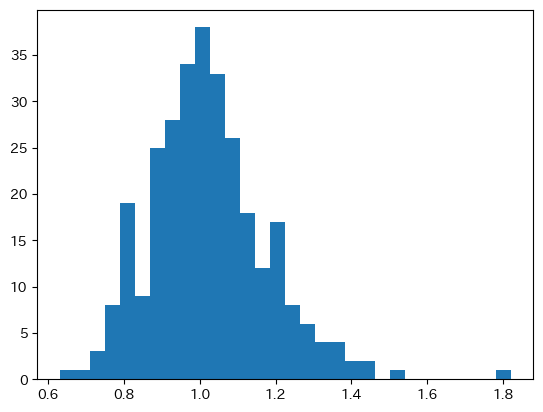

In [108]:
plt.hist(thetaK421,bins = 30)

In [60]:
k_0 = 2
theta = [1,1,1,1]
seed = 3
dt = 0.0001
h = 0.1
Z_t = linear_Z(theta, t_max, dt, 5)
Z = Z_t[:, ::int(h // dt)]


array([1.07192724, 0.91786204])

In [63]:
np.linalg.inv(sahennogyouretu(Z,h)) @ uhen(1,1,Z,1,h)

array([1.07192724, 0.86786204])

In [77]:
np.linalg.inv(sahennogyouretu(Z,h)) @ uhen(1,1,Z,2,h)

array([1.11517824, 1.23003104])

In [28]:
theta21_ = {}
theta22_ = {}

for k in range(1,8):
    theta21_[k] = np.array([])
    theta22_[k] = np.array([])

def uhen_(theta21,Z,k0,h):
    theta1 = 1
    theta3 = 1
    theta22 = 1
    theta = np.array([theta1,theta21,theta22,theta3])
    a = compute_a(theta,k0)
    b = compute_b(theta,k0)
    Z1 = Z[:,1:]
    Z2 = Z[:,:-1]
    x = Z1[0]
    y = Z1[1]
    x_ = Z2[0]
    y_ = Z2[1]

    if k0 == 1:
        f = 0
    else:
        x_ = x_[:,np.newaxis]
        y_ = y_[:,np.newaxis]
        k = np.arange(2,k0+1)
        f = np.sum((a[k]* x_ + b[k] * y_ )* h**k/scipy.special.factorial(k),axis =1)
    Dx =  (x - x_ - f)
    return - np.sum(Dx*x_)
def sahennogyouretu_(Z,h):
    Z1 = Z[:,1:]
    Z2 = Z[:,:-1]
    x = Z1[0]
    y = Z1[1]
    x_ = Z2[0]
    y_ = Z2[1]
    gyouretu = np.zeros((2,2))
    gyouretu[0,0] = np.sum(x_*x_)
    gyouretu[0,1] = np.sum(x_*y_)
    gyouretu[1,0] = np.sum(y_*x_)
    gyouretu[1,1] = np.sum(y_*y_)
    # x_**2, y_*x_, x_*y_ , y_**2を成分にもつ対角行列を作る
    return h * np.sum(x_*x_)
# for seed in tqdm.tqdm(range(3)):
#     theta = [1, 1, 1, 1]
#     t_max = 100.0
#     dt = 0.0001  # 最大時間の例
#     h = 0.5
#     Z_t = linear_Z(theta, t_max, dt, seed)
#     Z = Z_t[:, ::int(h // dt)]
#     for k0 in range(1,7):
#         if k0 == 1:
#             theta21_[k0] = np.append(theta21_[k0],(np.linalg.inv(sahennogyouretu(Z,h))@uhen(0,0,Z,k0,h))[0])
#             theta22_[k0] = np.append(theta22_[k0],(np.linalg.inv(sahennogyouretu(Z,h))@uhen(0,0,Z,k0,h))[1])
#         else:
#             theta21_[k0] = np.append(theta21_[k0],(np.linalg.inv(sahennogyouretu(Z,h))@uhen(theta21_[k0-1][-1],theta22_[k0-1][-1],Z,k0,h))[0])
#             theta22_[k0] = np.append(theta22_[k0],(np.linalg.inv(sahennogyouretu(Z,h))@uhen(theta21_[k0-1][-1],theta22_[k0-1][-1],Z,k0,h))[1])
        
# theta21_
# #theta2_のそれぞれの行の統計量を計算

In [30]:

theta2_ = {}
for k in range(1, 8):
    theta2_[k] = np.array([])

for seed in tqdm.tqdm(range(50)):
    theta = [1, 1, 1, 0]
    t_max = 400.0
    dt = 0.0001  # 最大時間の例
    h = 0.1
    Z_t = linear_Z(theta, t_max, dt, seed)
    Z = Z_t[:, ::int(h // dt)]
    theta2 = np.linspace(0.01, 10, 100)
    Q_list = theta2.copy()
    
    for k in range(1, 8):
        if k == 1:
            theta2_[k] = np.append(theta2_[k], (1/sahennogyouretu_(Z,h)) * uhen_(1,Z,1,h))
        else:
            # ニュートン法を行う
            theta_k = theta2_[k - 1][-1]  # 前のkの最適なθを初期値として使用
            tolerance = 1e-5
            Q_val = QL(Z, np.array([1, theta_k, 1, 0]),np.array([1, theta_k, 1, 0]), k, h)
            Q_prime = (QL(Z, np.array([1, theta_k + tolerance, 1, 0]), np.array([1, theta_k, 1, 0]), k, h) - Q_val) / tolerance
            Q_double_prime = (QL(Z, np.array([1, theta_k +  tolerance, 1, 0]), np.array([1, theta_k, 1, 0]), k, h) - 2 * Q_val + QL(Z, np.array([1, theta_k - tolerance, 1, 0]), np.array([1, theta_k, 1, 0]), k, h)) / (tolerance ** 2)
            if Q_double_prime == 0:
                print('error')
                theta2_[k] = np.append(theta2_[k], theta_k)    
            else:
                theta_new = theta_k - Q_prime / Q_double_prime
                theta2_[k] = np.append(theta2_[k], theta_new)

theta2_ = pd.DataFrame(theta2_)
#theta2_のそれぞれの行の統計量を計算
theta2_.describe()

100%|██████████| 50/50 [03:02<00:00,  3.65s/it]


,1,2,3,4,5,6,7
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.949458,0.995244,0.998112,0.998443,0.998475,0.998478,0.998479
std,0.120998,0.132901,0.134017,0.134192,0.134213,0.134216,0.134216
min,0.743792,0.771448,0.772778,0.772892,0.772900,0.772901,0.772901
25%,0.853498,0.889922,0.891916,0.892113,0.892129,0.892130,0.892130
50%,0.913578,0.955306,0.957751,0.958008,0.958031,0.958033,0.958033
75%,1.012854,1.064150,1.067461,1.067850,1.067888,1.067892,1.067892
max,1.253458,1.332020,1.338230,1.339135,1.339245,1.339259,1.339261


In [31]:

theta2_ = {}
for k in range(1, 8):
    theta2_[k] = np.array([])

for seed in tqdm.tqdm(range(50)):
    theta = [1, 1, 1, 0]
    t_max = 400.0
    dt = 0.0001  # 最大時間の例
    h = 0.1
    Z_t = linear_Z(theta, t_max, dt, seed)
    Z = Z_t[:, ::int(h // dt)]
    theta2 = np.linspace(0.01, 10, 100)
    Q_list = theta2.copy()
    
    for k in range(1, 8):
        if k == 1:
            theta2_[k] = np.append(theta2_[k], (1/sahennogyouretu_(Z,h)) * uhen_(1,Z,1,h))
        else:
            # ニュートン法を行う
            theta_k = theta2_[k - 1][-1]  # 前のkの最適なθを初期値として使用
            tolerance = 1e-5
            Q_val = QL(Z, np.array([1, theta_k, 1, 0]),np.array([1, theta_k, 1, 0]), k, h)
            Q_prime = (QL(Z, np.array([1, theta_k + tolerance, 1, 0]), np.array([1, theta_k, 1, 0]), k, h) - Q_val) / tolerance
            Q_double_prime = (QL(Z, np.array([1, theta_k +  tolerance, 1, 0]), np.array([1, theta_k, 1, 0]), k, h) - 2 * Q_val + QL(Z, np.array([1, theta_k - tolerance, 1, 0]), np.array([1, theta_k, 1, 0]), k, h)) / (tolerance ** 2)
            if Q_double_prime == 0:
                print('error')
                theta2_[k] = np.append(theta2_[k], theta_k)    
            else:
                theta_new = theta_k - Q_prime / Q_double_prime
                theta2_[k] = np.append(theta2_[k], theta_new)

theta2_ = pd.DataFrame(theta2_)
#theta2_のそれぞれの行の統計量を計算
theta2_.describe()

100%|██████████| 50/50 [17:48<00:00, 21.37s/it]


,1,2,3,4,5,6,7
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.963092,1.009646,1.012537,1.012863,1.012894,1.012897,1.012897
std,0.060868,0.066761,0.067307,0.067389,0.067399,0.067400,0.067400
min,0.837862,0.872964,0.874852,0.875034,0.875049,0.875050,0.875050
25%,0.920152,0.962508,0.964982,0.965245,0.965268,0.965270,0.965271
50%,0.968800,1.015734,1.018635,1.018960,1.018990,1.018993,1.018993
75%,1.005658,1.056225,1.059469,1.059847,1.059884,1.059888,1.059888
max,1.134630,1.198970,1.203631,1.204243,1.204310,1.204318,1.204319


In [ ]:

theta2_ = {}
for k in range(1, 8):
    theta2_[k] = np.array([])

for seed in tqdm.tqdm(range(3)):
    theta = [1, 1, 1, 0]
    t_max = 100.0
    dt = 0.0001  # 最大時間の例
    h = 0.5
    Z_t = linear_Z(theta, t_max, dt, seed)
    Z = Z_t[:, ::int(h // dt)]
    theta2 = np.linspace(0.01, 10, 100)
    Q_list = theta2.copy()
    
    for k in range(1, 8):
        if k == 1:
            for i in range(100):
                Q_list[i] = QL(Z, np.array([1, theta2[i], 1, 0]),np.array([1, theta2[i], 1, 0]), k, h)
            index = np.argmax(Q_list)
            theta2_[k] = np.append(theta2_[k], theta2[index])
        else:
            # ニュートン法を行う
            theta_k = theta2_[k - 1][-1]  # 前のkの最適なθを初期値として使用
            tolerance = 1e-5
            Q_val = QL(Z, np.array([1, theta_k, 1, 0]),np.array([1, theta_k, 1, 0]), k, h)
            Q_prime = (QL(Z, np.array([1, theta_k + tolerance, 1, 0]), np.array([1, theta_k, 1, 0]), k, h) - Q_val) / tolerance
            Q_double_prime = (QL(Z, np.array([1, theta_k +  tolerance, 1, 0]), np.array([1, theta_k, 1, 0]), k, h) - 2 * Q_val + QL(Z, np.array([1, theta_k - tolerance, 1, 0]), np.array([1, theta_k, 1, 0]), k, h)) / (tolerance ** 2)
            if Q_double_prime == 0:
                print('error')
                theta2_[k] = np.append(theta2_[k], theta_k)    
            else:
                theta_new = theta_k - Q_prime / Q_double_prime
                theta2_[k] = np.append(theta2_[k], theta_new)

theta2_ = pd.DataFrame(theta2_)
#theta2_のそれぞれの行の統計量を計算
theta2_.describe()


In [28]:

theta2_ = {}
for k in range(1, 8):
    theta2_[k] = np.array([])

for seed in tqdm.tqdm(range(3)):
    theta = [1, 1, 1, 1]
    t_max = 300.0
    dt = 0.0001  # 最大時間の例
    h = 0.5
    Z_t = linear_Z(theta, t_max, dt, seed)
    Z = Z_t[:, ::int(h // dt)]
    theta2 = np.linspace(0.01, 10, 10000)
    Q_list = theta2.copy()
    # k =1の場合はexplicitに解いてみる
    for k in range(1, 8):
        if k == 1:
            for i in range(10000):
                Q_list[i] = QL(Z, np.array([1, theta2[i], 1, 1]),np.array([1, theta2[i], 1, 1]), k, h)
            index = np.argmax(Q_list)
            theta2_[k] = np.append(theta2_[k], theta2[index])
        else:
            # ニュートン法を行う
            theta_k = theta2_[k - 1][-1]  # 前のkの最適なθを初期値として使用
            tolerance = 1e-5
            Q_val = QL(Z, np.array([1, theta_k, 1, 1]),np.array([1, theta_k, 1, 1]), k, h)
            Q_prime = (QL(Z, np.array([1, theta_k + tolerance, 1, 1]), np.array([1, theta_k, 1, 1]), k, h) - Q_val) / tolerance
            Q_double_prime = (QL(Z, np.array([1, theta_k +  tolerance, 1, 1]), np.array([1, theta_k, 1, 1]), k, h) - 2 * Q_val + QL(Z, np.array([1, theta_k - tolerance, 1, 1]), np.array([1, theta_k, 1, 1]), k, h)) / (tolerance ** 2)
            if Q_double_prime == 0:
                print('error')
                theta2_[k] = np.append(theta2_[k], theta_k)    
            else:
                theta_new = theta_k - Q_prime / Q_double_prime
                theta2_[k] = np.append(theta2_[k], theta_new)

theta2_ = pd.DataFrame(theta2_)
#theta2_のそれぞれの行の統計量を計算
theta2_.describe()


100%|██████████| 3/3 [00:39<00:00, 13.32s/it]


,1,2,3,4,5,6,7
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.959811,0.944302,0.973288,0.971484,0.971428,0.971445,0.971444
std,0.075194,0.098270,0.100145,0.099361,0.099418,0.099420,0.099420
min,0.879217,0.834250,0.862532,0.861565,0.861436,0.861451,0.861451
25%,0.925675,0.904816,0.931203,0.929764,0.929699,0.929713,0.929712
50%,0.972133,0.975382,0.999873,0.997964,0.997962,0.997974,0.997974
75%,1.000108,0.999327,1.028665,1.026443,1.026425,1.026442,1.026441
max,1.028083,1.023273,1.057457,1.054922,1.054887,1.054909,1.054908


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/db/b1td2bb97db6ppr5q5fk5_xc0000gn/T/ipykernel_39151/1772219949.py:26: RuntimeWarning: invalid value encountered in multiply
  f = np.sum((a[k]* x_ + b[k] * y_ )* h**k/scipy.special.factorial(k),axis =1)
/var/folders/db/b1td2bb97db6ppr5q5fk5_xc0000gn/T/ipykernel_39151/1772219949.py:26: RuntimeWarning: invalid value encountered in add
  f = np.sum((a[k]* x_ + b[k] * y_ )* h**k/scipy.special.factorial(k),axis =1)
100%|██████████| 3/3 [00:10<00:00,  3.64s/it]


{1: array([-226.53544915, -211.56477691, -184.4597185 ]),
 2: array([2559275.85273109, 2227650.31183069, 1691942.38341582]),
 3: array([-1.39691257e+20, -9.21210783e+19, -4.03621632e+19]),
 4: array([3.96648366e+80, 7.50178854e+79, 2.76456309e+78]),
 5: array([nan, nan, nan]),
 6: array([nan, nan, nan]),
 7: array([], dtype=float64)}

{1: array([-226.53544915, -211.56477691, -184.4597185 ]),
 2: array([2559275.85273109, 2227650.31183069, 1691942.38341582]),
 3: array([-1.39691257e+20, -9.21210783e+19, -4.03621632e+19]),
 4: array([3.96648366e+80, 7.50178854e+79, 2.76456309e+78]),
 5: array([nan, nan, nan]),
 6: array([nan, nan, nan]),
 7: array([], dtype=float64)}

In [35]:
theta21_ = {}
theta22_ = {}

for k in range(1,8):
    theta21_[k] = np.array([])
    theta22_[k] = np.array([])

def uhen(theta21,theta22,Z,k0,h):
    theta1 = 1
    theta3 = 1
    theta = np.array([theta1,theta21,theta22,theta3])
    a = compute_a(theta,k0)
    b = compute_b(theta,k0)
    Z1 = Z[:,1:]
    Z2 = Z[:,:-1]
    x = Z1[0]
    y = Z1[1]
    x_ = Z2[0]
    y_ = Z2[1]
    x = x[:,np.newaxis]
    y = y[:,np.newaxis]
    x_ = x_[:,np.newaxis]
    y_ = y_[:,np.newaxis]
    if k0 == 1:
        f = 0
    else:
        k = np.arange(2,k0+1)
        f = np.sum((a[k]* x_ + b[k] * y_ )* h**k/scipy.special.factorial(k),axis =1)
    Dx =  (x - x_ - f)
    return - np.array([np.sum(Dx*x_),np.sum(Dx*y_)])
def sahennogyouretu(Z,h):
    Z1 = Z[:,1:]
    Z2 = Z[:,:-1]
    x = Z1[0]
    y = Z1[1]
    x_ = Z2[0]
    y_ = Z2[1]
    gyouretu = np.zeros((2,2))
    gyouretu[0,0] = np.sum(x_*x_)
    gyouretu[0,1] = np.sum(x_*y_)
    gyouretu[1,0] = np.sum(y_*x_)
    gyouretu[1,1] = np.sum(y_*y_)
    # x_**2, y_*x_, x_*y_ , y_**2を成分にもつ対角行列を作る
    return h * gyouretu
for seed in tqdm.tqdm(range(3)):
    theta = [1, 1, 1, 1]
    t_max = 100.0
    dt = 0.0001  # 最大時間の例
    h = 0.5
    Z_t = linear_Z(theta, t_max, dt, seed)
    Z = Z_t[:, ::int(h // dt)]
    for k0 in range(1,7):
        if k0 == 1:
            theta21_[k0] = np.append(theta21_[k0],(np.linalg.inv(sahennogyouretu(Z,h))@uhen(0,0,Z,k0,h))[0])
            theta22_[k0] = np.append(theta22_[k0],(np.linalg.inv(sahennogyouretu(Z,h))@uhen(0,0,Z,k0,h))[1])
        else:
            theta21_[k0] = np.append(theta21_[k0],(np.linalg.inv(sahennogyouretu(Z,h))@uhen(1,1,Z,k0,h))[0])
            theta22_[k0] = np.append(theta22_[k0],(np.linalg.inv(sahennogyouretu(Z,h))@uhen(1,1,Z,k0,h))[1])
        

#theta2_のそれぞれの行の統計量を計算

100%|██████████| 3/3 [00:12<00:00,  4.08s/it]


In [36]:
theta21_ 

{1: array([0.86603726, 0.94140779, 1.07688119]),
 2: array([173.19356961, 188.28788295, 215.4349739 ]),
 3: array([173.19892584, 188.29108431, 215.43839148]),
 4: array([173.19854552, 188.29055236, 215.43674062]),
 5: array([173.1985166 , 188.29056554, 215.43686298]),
 6: array([173.19852218, 188.29056888, 215.43686654]),
 7: array([], dtype=float64)}

In [37]:
theta22_

{1: array([0.64179211, 1.01175349, 0.91180569]),
 2: array([128.3636309 , 202.35343955, 182.53649255]),
 3: array([128.36162126, 202.354827  , 182.54669563]),
 4: array([128.36176396, 202.35459646, 182.54176701]),
 5: array([128.36177481, 202.35460217, 182.54213233]),
 6: array([128.36177271, 202.35460362, 182.54214296]),
 7: array([], dtype=float64)}

In [38]:
# theta21_のキーを0とするものを除外

theta21_

{1: array([0.86603726, 0.94140779, 1.07688119]),
 2: array([173.19356961, 188.28788295, 215.4349739 ]),
 3: array([173.19892584, 188.29108431, 215.43839148]),
 4: array([173.19854552, 188.29055236, 215.43674062]),
 5: array([173.1985166 , 188.29056554, 215.43686298]),
 6: array([173.19852218, 188.29056888, 215.43686654]),
 7: array([], dtype=float64)}

In [44]:
import numpy as np
import pandas as pd
import tqdm

def process_data(num_seeds, t_max, dt, h):
    theta21_ = {0: np.array([0])}
    theta22_ = {0: np.array([0])}
    theta2_ = {}

    def uhen(theta21, theta22, Z, k0, h):
        theta1 = 1
        theta3 = 1
        theta = np.array([theta1, theta21, theta22, theta3])
        a = compute_a(theta, k0)
        b = compute_a(theta, k0)  # 仮の計算

        Z1 = Z[:, 1:]
        Z2 = Z[:, :-1]
        x = Z1[0]
        y = Z1[1]
        x_ = Z2[0]
        y_ = Z2[1]
        x = x[:, np.newaxis]
        y = y[:, np.newaxis]
        x_ = x_[:, np.newaxis]
        y_ = y_[:, np.newaxis]
        if k0 == 1:
            f = 0
        else:
            k = np.arange(2, k0 + 1)
            f = np.sum((a[k] * x_ + b[k] * y_) * h**k / scipy.special.factorial(k), axis=1)
        Dx = h**(-1/2) * (x - x_ - f)
        return -np.array([np.sum(Dx * x_), np.sum(Dx * y_), np.sum(Dx), np.sum(Dx**2)])

    def sahennogyouretu(Z, h):
        Z1 = Z[:, 1:]
        Z2 = Z[:, :-1]
        x = Z1[0]
        y = Z1[1]
        x_ = Z2[0]
        y_ = Z2[1]
        gyouretu = np.zeros((2, 2))
        gyouretu[0, 0] = np.sum(x_ * x_)
        gyouretu[0, 1] = np.sum(x_ * y_)
        gyouretu[1, 0] = np.sum(y_ * x_)
        gyouretu[1, 1] = np.sum(y_ * y_)
        return h * gyouretu

    for seed in tqdm.tqdm(range(num_seeds)):
        theta = [1, 1, 1, 1]
        Z_t = linear_Z(theta, t_max, dt, seed)
        Z = Z_t[:, ::int(h // dt)]
        for k0 in range(1, 8):
            if k0 not in theta21_:
                theta21_[k0] = np.array([])
            if k0 not in theta22_:
                theta22_[k0] = np.array([])
            sahen = np.linalg.inv(sahennogyouretu(Z, h))
            uhen_vec = uhen(theta21_[k0 - 1][-1], theta22_[k0 - 1][-1], Z, k0, h)
            theta21_[k0] = np.append(theta21_[k0], (sahen @ uhen_vec)[0])
            theta22_[k0] = np.append(theta22_[k0], (sahen @ uhen_vec)[1])

    theta2_ = {k: np.column_stack((theta21_[k], theta22_[k])) for k in theta21_}
    theta2_df = pd.DataFrame.from_dict(theta2_, orient='index')

    return theta2_df.describe()

# 関数の呼び出し
num_seeds = 30
t_max = 100.0
dt = 0.0001
h = 0.5
theta2_stats = process_data(num_seeds, t_max, dt, h)

# 結果の表示
print(theta2_stats)

  0%|          | 0/30 [00:03<?, ?it/s]


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 2)

In [41]:
# 初期化
theta21_ = {0: np.array([0])}
theta22_ = {0: np.array([0])}
theta2_ = {0: np.array([[0, 0]])}  # 初期化

def uhen(theta21, theta22, Z, k0, h):
    theta1 = 1
    theta3 = 1
    theta = np.array([theta1, theta21, theta22, theta3])
    a = compute_a(theta, k0)
    b = compute_a(theta, k0)  # 仮の計算

    Z1 = Z[:, 1:]
    Z2 = Z[:, :-1]
    x = Z1[0][:, np.newaxis]
    y = Z1[1][:, np.newaxis]
    x_ = Z2[0][:, np.newaxis]
    y_ = Z2[1][:, np.newaxis]
    if k0 == 1:
        f = 0
    else:
        k = np.arange(2, k0 + 1)
        f = np.sum((a[k] * x_ + b[k] * y_) * h**k / scipy.special.factorial(k), axis=1)
    Dx = h**(-1/2) * (x - x_ - f)
    return -np.array([np.sum(Dx * x_), np.sum(Dx * y_), np.sum(Dx), np.sum(Dx**2)])

def sahennogyouretu(Z, h):
    Z1 = Z[:, 1:]
    Z2 = Z[:, :-1]
    x = Z1[0]
    y = Z1[1]
    x_ = Z2[0]
    y_ = Z2[1]
    gyouretu = np.zeros((2, 2))
    gyouretu[0, 0] = np.sum(x_ * x_)
    gyouretu[0, 1] = np.sum(x_ * y_)
    gyouretu[1, 0] = np.sum(y_ * x_)
    gyouretu[1, 1] = np.sum(y_ * y_)
    return h * gyouretu

for seed in tqdm.tqdm(range(30)):
    theta = [1, 1, 1, 1]
    t_max = 100.0
    dt = 0.0001  # 最大時間の例
    h = 0.5
    Z_t = linear_Z(theta, t_max, dt, seed)
    Z = Z_t[:, ::int(h // dt)]
    for k0 in range(1, 8):
        if k0 not in theta21_:
            theta21_[k0] = np.array([])
        if k0 not in theta22_:
            theta22_[k0] = np.array([])
        sahen = np.linalg.inv(sahennogyouretu(Z, h))
        uhen_vec = uhen(theta21_[k0 - 1][-1], theta22_[k0 - 1][-1], Z, k0, h)
        theta21_[k0] = np.append(theta21_[k0], (sahen @ uhen_vec)[0])
        theta22_[k0] = np.append(theta22_[k0], (sahen @ uhen_vec)[1])

# 結果を DataFrame に変換
theta2_ = {k: np.column_stack((theta21_[k], theta22_[k])) for k in theta21_}
theta2_df = pd.DataFrame.from_dict(theta2_, orient='index')

# 統計量を計算
theta2_stats = theta2_df.describe()

# 結果を表示
print(theta2_stats)

  0%|          | 0/30 [00:03<?, ?it/s]


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 2)

In [111]:

theta2_ = {}
for k in range(1, 8):
    theta2_[k] = np.array([])

for seed in tqdm.tqdm(range(30)):
    theta = [1, 1, 1, 1]
    t_max = 100.0
    dt = 0.0001  # 最大時間の例
    h = 0.5
    Z_t = linear_Z(theta, t_max, dt, seed)
    Z = Z_t[:, ::int(h // dt)]
    theta2 = np.linspace(0.01, 5, 100)
    Q_list = theta2.copy()
    
    for k in range(1, 8):
        if k == 1:
            for i in range(100):
                Q_list[i] = QL(Z, np.array([1, theta2[i], 1, 1]),np.array([1, theta2[i], 1, 1]), k, h)
            index = np.argmax(Q_list)
            theta2_[k] = np.append(theta2_[k], theta2[index])
        else:
            # ニュートン法を行う
            theta_k = theta2_[k - 1][-1]  # 前のkの最適なθを初期値として使用
            tolerance = 1e-5
            Q_val = QL(Z, np.array([1, theta_k, 1, 1]),np.array([1, theta_k, 1, 1]), k, h)
            Q_prime = (QL(Z, np.array([1, theta_k + tolerance, 1, 1]), np.array([1, theta_k, 1, 1]), k, h) - Q_val) / tolerance
            Q_double_prime = (QL(Z, np.array([1, theta_k +  tolerance, 1, 1]), np.array([1, theta_k, 1, 1]), k, h) - 2 * Q_val + QL(Z, np.array([1, theta_k - tolerance, 1, 1]), np.array([1, theta_k, 1, 1]), k, h)) / (tolerance ** 2)
            if Q_double_prime == 0:
                print('error')
                theta2_[k] = np.append(theta2_[k], theta_k)    
            else:
                theta_new = theta_k - Q_prime / Q_double_prime
                theta2_[k] = np.append(theta2_[k], theta_new)

theta2_ = pd.DataFrame(theta2_)
#theta2_のそれぞれの行の統計量を計算
theta2_.describe()


100%|██████████| 30/30 [01:52<00:00,  3.75s/it]


,1,2,3,4,5,6,7
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.969357,0.954439,0.990738,1.003221,1.009288,1.012374,1.013959
std,0.107114,0.158060,0.177278,0.188090,0.194858,0.198921,0.201395
min,0.816465,0.745058,0.762070,0.766469,0.767781,0.768335,0.768551
25%,0.879470,0.834071,0.859909,0.867148,0.869895,0.871087,0.871582
50%,0.967677,0.943825,0.976035,0.985521,0.989714,0.991639,0.992500
75%,1.018081,1.015273,1.054813,1.067596,1.073759,1.076719,1.078123
max,1.320505,1.507509,1.622583,1.687186,1.726935,1.751445,1.766752


In [25]:
import pandas as pd

In [55]:

theta2_ = {}
for k in range(1, 8):
    theta2_[k] = np.array([])

for seed in tqdm.tqdm(range(5)):
    theta = [1, 1, 0, 1]
    t_max = 100.0
    dt = 0.0001  # 最大時間の例
    h = 0.5
    Z_t = linear_Z(theta, t_max, dt, seed)
    Z = Z_t[:, ::int(h // dt)]
    theta2 = np.linspace(0.01, 5, 10000)
    Q_list = theta2.copy()
    
    for k in range(1, 8):
        if k == 1:
            for i in range(10000):
                Q_list[i] = QL(Z, np.array([1, theta2[i], 0, 1]),np.array([1, theta2[i], 0, 1]), k, h)
            index = np.argmax(Q_list)
            theta2_[k] = np.append(theta2_[k], theta2[index])
        else:
            # ニュートン法を行う
            theta_k = theta2_[k - 1][-1]  # 前のkの最適なθを初期値として使用
            tolerance = 1e-5
            Q_val = QL(Z, np.array([1, theta_k, 0, 1]),np.array([1, theta_k, 0, 1]), k, h)
            Q_prime = (QL(Z, np.array([1, theta_k + tolerance, 0, 1]), np.array([1, theta_k, 0, 1]), k, h) - Q_val) / tolerance
            Q_double_prime = (QL(Z, np.array([1, theta_k +  tolerance, 0, 1]), np.array([1, theta_k, 0, 1]), k, h) - 2 * Q_val + QL(Z, np.array([1, theta_k - tolerance, 0, 1]), np.array([1, theta_k, 0, 1]), k, h)) / (tolerance ** 2)
            if Q_double_prime == 0:
                print('error')
                theta2_[k] = np.append(theta2_[k], theta_k)    
            else:
                theta_new = theta_k - Q_prime / Q_double_prime
                theta2_[k] = np.append(theta2_[k], theta_new)

theta2_ = pd.DataFrame(theta2_)
#theta2_のそれぞれの行の統計量を計算
theta2_.describe()


100%|██████████| 5/5 [00:26<00:00,  5.32s/it]


,1,2,3,4,5,6,7
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.855590,1.042910,1.084525,1.109637,1.119787,1.124483,1.126613
std,0.146312,0.201922,0.216938,0.228071,0.232982,0.235412,0.236562
min,0.595885,0.684872,0.699979,0.705554,0.707118,0.707589,0.707728
25%,0.898309,1.099792,1.145016,1.172226,1.183151,1.188127,1.190342
50%,0.908290,1.114469,1.161052,1.189478,1.200996,1.206301,1.208689
75%,0.931246,1.148103,1.197773,1.229078,1.242015,1.248127,1.250945
max,0.944221,1.167314,1.218804,1.251850,1.265654,1.272269,1.275361


In [26]:
theta2_ = pd.DataFrame(theta2_)
#theta2_のそれぞれの行の統計量を計算
theta2_.describe()

,1,2,3,4,5,6,7
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.868486,1.035413,1.023200,1.027078,1.026718,1.026749,1.026747
std,0.116230,0.165212,0.161644,0.164366,0.164055,0.164087,0.164084
min,0.616845,0.694321,0.689425,0.690027,0.689993,0.689994,0.689994
25%,0.800246,0.936894,0.926921,0.929047,0.928886,0.928897,0.928897
50%,0.841417,0.993840,0.982515,0.985246,0.985027,0.985043,0.985042
75%,0.952581,1.152503,1.137467,1.142610,1.142132,1.142173,1.142170
max,1.160310,1.465545,1.445620,1.460283,1.458542,1.458735,1.458718


$\theta_2$の実験, $h=0.9$,他のパラメータは真値をとる，最初はM推定量でワンステップ

In [133]:

theta2_ = {}
for k in range(1, 8):
    theta2_[k] = np.array([])

for seed in tqdm.tqdm(range(30)):
    theta = [1, 1, 1, 1]
    t_max = 100.0
    dt = 0.0001  # 最大時間の例
    h = 0.9
    Z_t = linear_Z(theta, t_max, dt, seed)
    Z = Z_t[:, ::int(h // dt)]
    theta2 = np.linspace(0.01, 5, 100)
    Q_list = theta2.copy()
    
    for k in range(1, 8):
        if k == 1:
            for i in range(100):
                Q_list[i] = QL(Z, np.array([1, theta2[i], 1, 1]),np.array([1, theta2[i], 1, 1]), k, h)
            index = np.argmax(Q_list)
            theta2_[k] = np.append(theta2_[k], theta2[index])
        else:
            # ニュートン法を行う
            theta_k = theta2_[k - 1][-1]  # 前のkの最適なθを初期値として使用
            tolerance = 1e-5
            Q_val = QL(Z, np.array([1, theta_k, 1, 1]),np.array([1, theta_k, 1, 1]), k, h)
            Q_prime = (QL(Z, np.array([1, theta_k + tolerance, 1, 1]), np.array([1, theta_k, 1, 1]), k, h) - Q_val) / tolerance
            Q_double_prime = (QL(Z, np.array([1, theta_k +  tolerance, 1, 1]), np.array([1, theta_k, 1, 1]), k, h) - 2 * Q_val + QL(Z, np.array([1, theta_k - tolerance, 1, 1]), np.array([1, theta_k, 1, 1]), k, h)) / (tolerance ** 2)
            if Q_double_prime == 0:
                print('error')
                theta2_[k] = np.append(theta2_[k], theta_k)    
            else:
                theta_new = theta_k - Q_prime / Q_double_prime
                theta2_[k] = np.append(theta2_[k], theta_new)

theta2_ = pd.DataFrame(theta2_)
#theta2_のそれぞれの行の統計量を計算
theta2_.describe()


100%|██████████| 30/30 [01:53<00:00,  3.79s/it]


,1,2,3,4,5,6,7
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.950875,0.893621,1.020976,1.024511,1.023634,1.023951,1.023946
std,0.110218,0.212328,0.230162,0.228946,0.231477,0.231135,0.231169
min,0.665253,0.556529,0.611886,0.617127,0.615862,0.615953,0.615957
25%,0.917273,0.758766,0.891895,0.909223,0.905987,0.906607,0.906604
50%,0.967677,0.888695,1.005059,1.015610,1.011916,1.012970,1.012917
75%,1.018081,1.016385,1.099908,1.098316,1.096004,1.097049,1.096954
max,1.270101,1.448862,1.807488,1.843636,1.853949,1.852321,1.852611


$\theta_2$の実験, $h=0.5$,他のパラメータは真値をとる，全部M推定量

In [54]:

theta2_ = {}
for k in range(1, 8):
    theta2_[k] = np.array([])

for seed in tqdm.tqdm(range(3)):
    theta = [1, 1, 1, 1]
    t_max = 100.0
    dt = 0.0001  # 最大時間の例
    h = 0.5
    Z_t = linear_Z(theta, t_max, dt, seed)
    Z = Z_t[:, ::int(h // dt)]
    theta2 = np.linspace(0.01, 5, 100)
    Q_list = theta2.copy()
    
    for k in range(1, 8):
        for i in range(100):
            Q_list[i] = QL(Z, np.array([1, theta2[i], 1, 1]), np.array([1, theta2[i], 1, 1]),k, h)
        index = np.argmax(Q_list)
        theta2_[k] = np.append(theta2_[k], theta2[index])
        
theta2_ = pd.DataFrame(theta2_)
#theta2_のそれぞれの行の統計量を計算
theta2_.describe()


100%|██████████| 3/3 [00:11<00:00,  3.82s/it]


,1,2,3,4,5,6,7
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.950875,0.883670,0.967677,0.967677,0.967677,0.967677,0.967677
std,0.104924,0.126847,0.133357,0.133357,0.133357,0.133357,0.133357
min,0.866869,0.766061,0.866869,0.866869,0.866869,0.866869,0.866869
25%,0.892071,0.816465,0.892071,0.892071,0.892071,0.892071,0.892071
50%,0.917273,0.866869,0.917273,0.917273,0.917273,0.917273,0.917273
75%,0.992879,0.942475,1.018081,1.018081,1.018081,1.018081,1.018081
max,1.068485,1.018081,1.118889,1.118889,1.118889,1.118889,1.118889
